# Base Models

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Importing Data

In [55]:
def read_data(path: str) -> pd.DataFrame:
    df_train = pd.read_feather(os.path.join(path, 'train_combined.feather'))
    df_test = pd.read_feather(os.path.join(path, 'test_combined.feather'))

    return df_train, df_test

In [56]:
df_train, df_test = read_data('../data')

## Creating base models before starting feature engineering

## Selecting split data

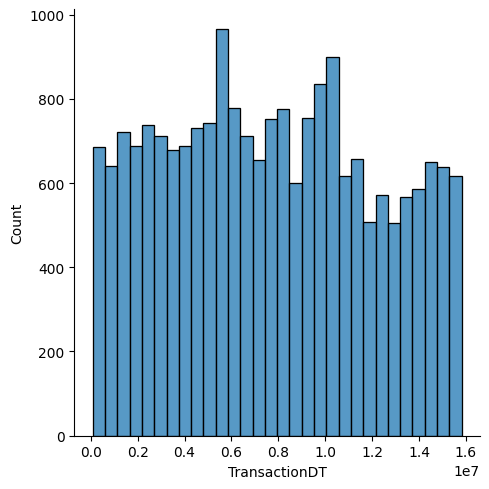

In [57]:
sns.displot(df_train[df_train['isFraud'] == True], x='TransactionDT')

From EDA we saw that the test data is set in time after the train data. Keeping that in mind and the fact that there are enough fraudulent transactions in each timeframe, we will split the data such as the test data will be at the end and the train data will be at the beginning.

In [58]:
def train_test_split(df: pd.DataFrame, ratio: float=0.8) -> pd.DataFrame:
    dff = df.copy()
    # dff = dff.sort_values(by='TransactionDT')

    idx_train = dff.index[:int(dff.shape[0] * ratio)]
    idx_test = dff.index[int(dff.shape[0] * ratio):]

    df_train = dff.iloc[idx_train]
    df_test = dff.iloc[idx_test]

    y_train = df_train['isFraud']
    x_train = df_train.drop(columns=['isFraud'])

    y_test = df_test['isFraud']
    x_test = df_test.drop(columns=['isFraud'])

    return x_train, y_train, x_test, y_test



In [59]:
x_train, y_train, x_test, y_test = train_test_split(df_train, 0.75)

## Training and evaluating models

### Logistic Pipeline

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [61]:
def numerical_cols(df: pd.DataFrame) -> list:
    l = list(df.select_dtypes(include='number'))
    # if 'isFraud' in l:
    #     l.remove('isFraud')
    return l

In [62]:
def inf_to_nan(df: pd.DataFrame) -> pd.DataFrame:
    return df.replace([np.inf, -np.inf], np.nan)

In [63]:
def fill_numerical_cols_and_scale(df: pd.DataFrame) -> pd.DataFrame:
    cols = numerical_cols(df)
    if 'isFraud' in cols:
        cols.remove('isFraud')
    dff = df.copy()
    dff[cols] = inf_to_nan(dff[cols])

    imputer = SimpleImputer(strategy='median')
    dff[cols] = imputer.fit_transform(dff[cols])

    scaler = StandardScaler()
    dff[cols] = scaler.fit_transform(dff[cols])

    return dff

In [64]:
def label_encoding(df: pd.DataFrame) -> pd.DataFrame:
    cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['DeviceType', 'DeviceInfo'] +
            ['M%d' % i for i in range(1, 10)] + 
            ['id_%d' % i for i in range(12, 39)])
    
    dff = df.copy()
    for col in cols:
        if col in dff.columns:
            dff[col] = dff[col].astype('object')
            dff[col] = dff[col].fillna('MISSING')

            lb = LabelEncoder()
            lb.fit(list(dff[col].values))
            dff[col] = lb.transform(list(dff[col].values))

            # dff[col] = dff[col].astype('category')
    
    return dff

In [65]:
def logistic_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    dff = df.copy()

    if 'TransactionDT' in dff.columns:
        dff = dff.sort_values(by='TransactionDT')
        dff = dff.drop(columns=['TransactionDT'])
    if 'TransactionID' in dff.columns:
        dff = dff.drop(columns=['TransactionID'])

    dff = inf_to_nan(dff)
    dff = fill_numerical_cols_and_scale(dff)
    dff = label_encoding(dff)

    return dff

In [66]:
dff = df_train.copy()
dff = logistic_pipeline(dff)

In [67]:
x_train, y_train, x_test, y_test = train_test_split(dff, 0.75)

In [68]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float64(382), int32(31), int64(19)
memory usage: 1.8 GB


### Logistic Regression

In [69]:
def logistic_regression(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame, y_test: pd.Series) -> float:

    model = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=10)
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

    sns.lineplot(x=fpr, y=tpr)
    plt.show()

    print('Area under roc {}'.format(auc(fpr, tpr)))

    return auc(fpr, tpr)

c:\Users\Codrin\.virtualenvs\IEEE_CIS_Fraud_Detection-GY5ZS6V-\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


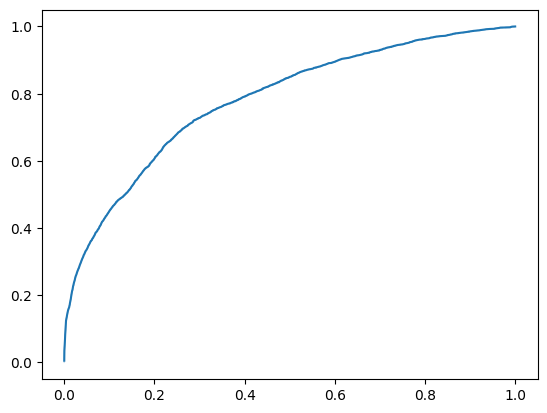

Area under roc 0.7804893356086602


0.7804893356086602

In [70]:
logistic_regression(x_train, y_train, x_test, y_test)

### XGBoost

In [71]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

In [72]:
def xg_boost(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame, y_test: pd.Series):
    clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,
        subsample=0.8, early_stopping_rounds=100, gpu_id=0)


    model = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=10)
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

    sns.lineplot(x=fpr, y=tpr)
    plt.show()

    print('Area under roc {}'.format(auc(fpr, tpr)))

    _, ax = plt.subplots(figsize=(10, 12), dpi=80)
    xgb.plot_importance(
        model,
        height=0.75,
        importance_type="gain",
        max_num_features=50,
        show_values=False,
        ax=ax,
    )
    plt.show()

    return auc(fpr, tpr)

#     params = {'n_estimators':[1000,2000],'max_depth':[3,6,12],'subsample':[0.4,0.8]}



#     clf = xgb.XGBClassifier( 
#             missing=-1, learning_rate=0.02,
#             eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4)


#     model = RandomizedSearchCV(estimator=clf, param_distributions=params, scoring='roc_auc', verbose=1, cv=3, n_iter=6)
#     model.fit(x_train,y_train)

#     print(model.best_params_)

[0]	validation_0-auc:0.81311
[10]	validation_0-auc:0.85568
[20]	validation_0-auc:0.86018
[30]	validation_0-auc:0.86147
[40]	validation_0-auc:0.86394
[50]	validation_0-auc:0.86625
[60]	validation_0-auc:0.86802
[70]	validation_0-auc:0.87050
[80]	validation_0-auc:0.87247
[90]	validation_0-auc:0.87452
[100]	validation_0-auc:0.87672
[110]	validation_0-auc:0.87849
[120]	validation_0-auc:0.88117
[130]	validation_0-auc:0.88351
[140]	validation_0-auc:0.88572
[150]	validation_0-auc:0.88813
[160]	validation_0-auc:0.89109
[170]	validation_0-auc:0.89335
[180]	validation_0-auc:0.89557
[190]	validation_0-auc:0.89738
[200]	validation_0-auc:0.89958
[210]	validation_0-auc:0.90124
[220]	validation_0-auc:0.90319
[230]	validation_0-auc:0.90487
[240]	validation_0-auc:0.90633
[250]	validation_0-auc:0.90766
[260]	validation_0-auc:0.90909
[270]	validation_0-auc:0.91048
[280]	validation_0-auc:0.91162
[290]	validation_0-auc:0.91308
[300]	validation_0-auc:0.91432
[310]	validation_0-auc:0.91556
[320]	validation_0-

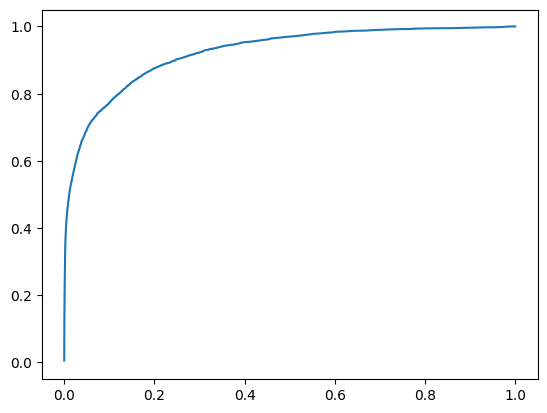

Area under roc 0.9234840868118391


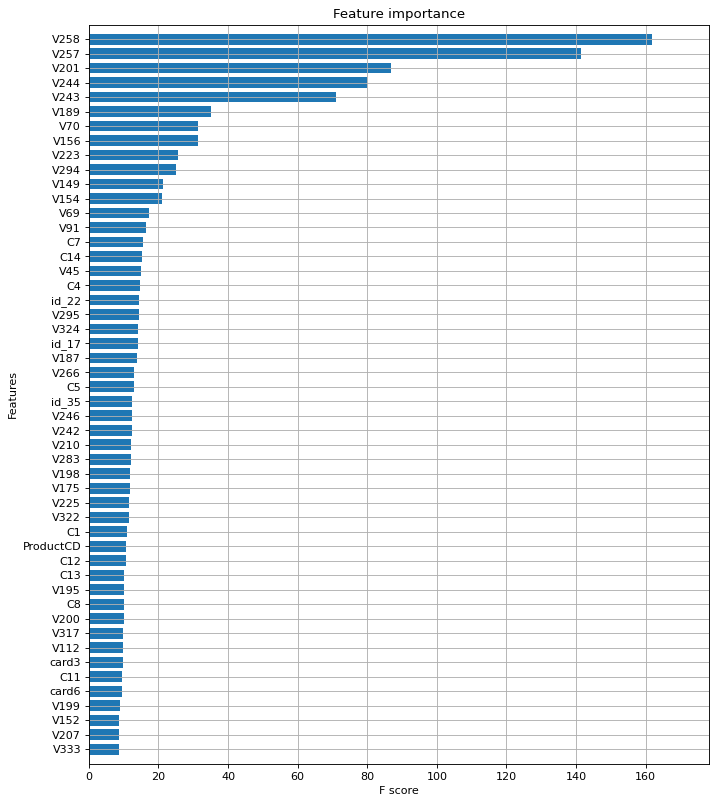

0.9234840868118391

In [73]:
xg_boost(x_train, y_train, x_test, y_test)